In [16]:
import matplotlib.pyplot as plt
# import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
%config InlineBackend.figure_format = 'retina'

In [4]:
class LinearModel:
    
    def __init__(self, data, target):
        self.data = data
        print("Init-Data: ", data)
        self.target = target
        print("Init-Target: ", target)
        self._prediction = None
        self._optimize = None
        self._error = None
        self._gradients = None
        self._hessians = None
        self._params = None
        
    @property
    def params(self):
        if  self._params is  None:
            data_dim = int(self.data.get_shape()[1])
            print("Params-data_dim: ", data_dim)
            target_dim = int(self.target.get_shape()[1])
            print("Params-target_dim: ", target_dim)
            # we construct one variable for both weight and bias
            self._params = tf.get_variable(name='params', shape=[data_dim+target_dim])
            print("Params-total_dim: ", data_dim + target_dim)
        return  self._params

    @property
    def prediction(self):
        if  self._prediction is  None:
            data_dim = int(self.data.get_shape()[1])
            print("Prediction-data_dim: ", data_dim)
            W = tf.reshape(self.params[:-1], [data_dim,1])
            print("Prediction-W: ", W)
            b = self.params[-1]
            print("Prediction-b: ", b)
            self._prediction = tf.matmul(self.data, W) + b
        return  self._prediction

    @property
    def error(self):
        if  self._error is  None:
            self._error = tf.losses.mean_squared_error(labels = self.target,
            predictions = self.prediction)
            print("error-self._error: ", self._error)
        return  self._error
    
    @property
    def optimize(self, lr  =  0.1):
        if  self._optimize is  None:
            train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(self.error)
            self._optimize = train_op
            print("optimize-self._optimize: ",self._optimize)
        return  self._optimize

    @property
    def  gradients(self):
        if  self._gradients is  None:
            self._gradients = tf.gradients(self.error, self.params)
            print("gradients-self._gradients", self._gradients)
        return  self._gradients

    @property
    def  hessians(self):
        if  self._hessians is  None:
            self._hessians = tf.hessians(self.error, self.params)
            print("hessians-self._hessians: ",self._hessians)
        return  self._hessians

In [5]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
# TRAIN_DATA_PATH = '/content/sample_data/california_housing_train.csv'
# TEST_DATA_PATH = '/content/sample_data/california_housing_test.csv'
TARGET_NAME = 'median_house_value'

In [6]:
# x_train = features, y_train = target
train_data = pd.read_csv('california_housing_train.csv')
test_data = pd.read_csv('california_housing_test.csv')
x_train, y_train = train_data.drop(TARGET_NAME, axis=1), train_data[TARGET_NAME]
x_test, y_test = test_data.drop(TARGET_NAME, axis=1), test_data[TARGET_NAME]

In [7]:
def scale_datasets(x_train, x_test):
    standard_scaler = StandardScaler()
    
    x_train_scaled = pd.DataFrame(standard_scaler.fit_transform(x_train), columns=x_train.columns)
    x_test_scaled = pd.DataFrame(standard_scaler.transform(x_test), columns = x_test.columns)
    
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

In [8]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
    return model
# build the model
model = build_model_using_sequential()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled.values, 
    y_train.values, 
    epochs=10, 
    batch_size=64,
    validation_split=0.2
)

Train on 13600 samples, validate on 3400 samples
Epoch 1/10
   64/13600 [..............................] - ETA: 19s - loss: 147.9614 - mean_squared_logarithmic_error: 147.9614

2022-06-23 12:01:37.264705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 12:01:37.264746: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 12:01:37.264770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pnans): /proc/driver/nvidia/version does not exist
2022-06-23 12:01:37.265090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13600/13600 [==============================] - 1s 54us/sample - loss: 5.2301 - mean_squared_logarithmic_error: 5.2186 - val_loss: 0.6737 - val_mean_squared_logarithmic_error: 0.6750
Epoch 2/10
 2432/13600 [====>.........................] - ETA: 0s - loss: 0.2914 - mean_squared_logarithmic_error: 0.2914

/home/pnans/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


13600/13600 [==============================] - 1s 54us/sample - loss: 0.2552 - mean_squared_logarithmic_error: 0.2549 - val_loss: 0.3724 - val_mean_squared_logarithmic_error: 0.3750
Epoch 3/10
13600/13600 [==============================] - 1s 63us/sample - loss: 0.1894 - mean_squared_logarithmic_error: 0.1894 - val_loss: 0.2697 - val_mean_squared_logarithmic_error: 0.2693
Epoch 4/10
13600/13600 [==============================] - 1s 66us/sample - loss: 0.1485 - mean_squared_logarithmic_error: 0.1486 - val_loss: 0.1939 - val_mean_squared_logarithmic_error: 0.1939
Epoch 5/10
13600/13600 [==============================] - 1s 54us/sample - loss: 0.1234 - mean_squared_logarithmic_error: 0.1235 - val_loss: 0.1502 - val_mean_squared_logarithmic_error: 0.1487
Epoch 6/10
13600/13600 [==============================] - 1s 55us/sample - loss: 0.1091 - mean_squared_logarithmic_error: 0.1091 - val_loss: 0.1296 - val_mean_squared_logarithmic_error: 0.1288
Epoch 7/10
13600/13600 [======================

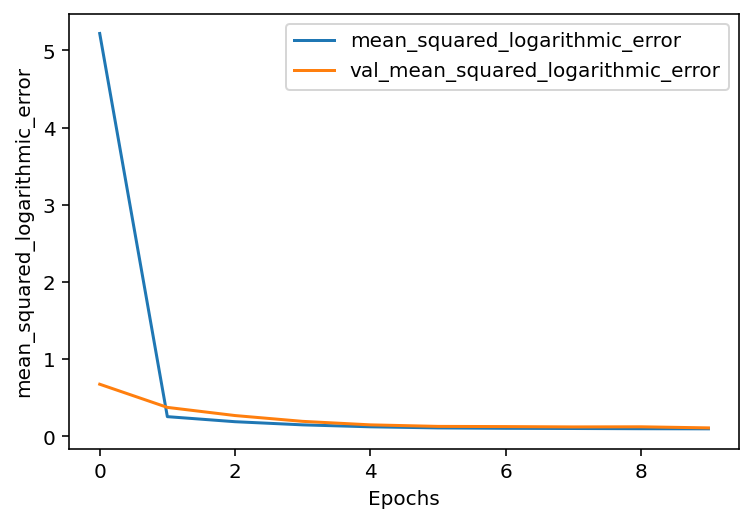

In [10]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [11]:
x_test['prediction'] = model.predict(x_test_scaled)
x_test

/home/pnans/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,prediction
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,350321.65625
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,193577.93750
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,266459.53125
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,333480.71875
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,92273.12500
...,...,...,...,...,...,...,...,...,...
2995,-119.86,34.42,23.0,1450.0,642.0,1258.0,607.0,1.1790,206606.25000
2996,-118.14,34.06,27.0,5257.0,1082.0,3496.0,1036.0,3.3906,150975.15625
2997,-119.70,36.30,10.0,956.0,201.0,693.0,220.0,2.2895,97271.50000
2998,-117.12,34.10,40.0,96.0,14.0,46.0,14.0,3.2708,126074.65625


In [12]:
#y_train.reshape(17000,1)
#y_train.reshape((17000, 1))

arr = y_train.values
y_train = arr.reshape((17000, 1))


arr = y_test.values
y_test = arr.reshape((3000, 1))

In [13]:
x_train_scaled = x_train_scaled.to_numpy()
x_test_scaled = x_test_scaled.to_numpy()

In [14]:
x_train_temp = x_train_scaled[1:10]
x_test_temp = x_test_scaled[1:10]
y_train_temp = y_train[1:10]
y_test_temp = y_test[1:10]

In [17]:
EPOCHS = 100
R = 1
num_train_points = x_train_temp.shape[0]

tf.reset_default_graph()
#tf.compat.v1.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(None, 8))
y_true = tf.placeholder(dtype=tf.float32, shape=(None, 1))

model = LinearModel(x, y_true)
train_op = model.optimize
loss_op = model.error
param_op = model.params
gradient_op = model.gradients
hessian_op = model.hessians

Init-Data:  Tensor("Placeholder:0", shape=(?, 8), dtype=float32)
Init-Target:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
Prediction-data_dim:  8
Params-data_dim:  8
Params-target_dim:  1
Params-total_dim:  9
Prediction-W:  Tensor("Reshape:0", shape=(8, 1), dtype=float32)
Prediction-b:  Tensor("strided_slice_1:0", shape=(), dtype=float32)
error-self._error:  Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
optimize-self._optimize:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_params/ApplyGradientDescent"

gradients-self._gradients [<tf.Tensor 'gradients_1/AddN:0' shape=(9,) dtype=float32>]
hessians-self._hessians:  [<tf.Tensor 'Reshape_2:0' shape=(9, 9) dtype=float32>]


In [18]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    print("init_op: ",init_op)    
    for e in  range(EPOCHS):
        if e == 0: print("x, y_true: ", x, y_true)
        fd = {x: x_train_temp, y_true: y_train_temp}
        _, loss_epoch = sess.run([train_op, loss_op], feed_dict = fd)
    p = sess.run(param_op)
    s_test = 0
    for r in  range(R):
        v = sess.run(gradient_op, feed_dict = {x:x_test_temp, y_true:y_test_temp})[0]
        s_test_j = v
        # print("r: ",r, " s_test_j: ",s_test_j, "\n")
        for j in  range(num_train_points):
            fd = {x:x_train_temp[j].reshape((1,-1)), y_true:y_train_temp[j].reshape((-1,1))}
            hess_param = sess.run(hessian_op, feed_dict = fd)[0]
            hess_param = np.diag(hess_param)
            # print("hess_param: ",hess_param)
            s_test_j = v + np.matmul((np.identity(9)-hess_param),s_test_j)
            print("s_test_j: ",s_test_j)
        s_test += s_test_j
    s_test = s_test/R
    print("s_test: ",s_test)
    importance = []
    for j in  range(num_train_points):
        fd = {x:x_train_temp[j].reshape((1,-1)), y_true:y_train_temp[j].reshape((-1,1))}
        grad_param = sess.run(gradient_op, feed_dict = fd)[0]
        print("grad_param: ", grad_param)
        importance.append(-np.matmul(s_test,grad_param))
        print("importance_last: ", importance[-1])

importance = np.asarray(importance)
print('Loss: {}'.format(((p[0]*x_test_temp+p[1]-y_test_temp)**2)[0]))

init_op:  name: "init"
op: "NoOp"
input: "^params/Assign"

x, y_true:  Tensor("Placeholder:0", shape=(?, 8), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
s_test_j:  [-3335817.61583582 -3249835.06114832 -3287332.20958582 -3097218.50646082
 -3049875.55333582 -3128621.67833582 -3060318.52208582 -3378518.77208582
 -3972882.77208582]
s_test_j:  [87509815.74902996 87638789.58106121 87582543.85840496 87867714.41309246
 87938728.84277996 87820609.65527996 87923064.38965496 87445764.01465496
 86554218.01465496]
s_test_j:  [-1.87049435e+09 -1.87032239e+09 -1.87039738e+09 -1.87001715e+09
 -1.86992247e+09 -1.87007996e+09 -1.86994335e+09 -1.87057975e+09
 -1.87176848e+09]
s_test_j:  [3.95672030e+10 3.95674180e+10 3.95673242e+10 3.95677995e+10
 3.95679179e+10 3.95677210e+10 3.95678918e+10 3.95670963e+10
 3.95656104e+10]
s_test_j:  [-7.42179343e+11 -7.42179085e+11 -7.42179197e+11 -7.42178627e+11
 -7.42178485e+11 -7.42178721e+11 -7.42178516e+11 -7.42179471e+11
 -7.42181254e+11]

In [22]:
importance

array([-2.85473718e+21,  1.12337468e+22, -4.95686705e+21, -6.52869924e+21,
        7.08794057e+20, -1.27838966e+22, -6.78699169e+20,  1.56705252e+22,
       -2.36613848e+20])

In [30]:
import os

data_path = os.path.join("/home/pnans/Documents/IIITD-2021/2022/Code/GraN-DAG-master/data/data_p10_e10_n1000_GP", "data1.npy")
data = np.load(data_path)

In [32]:
data.shape

(1000, 10)